# Classification - Count - BoW

This notebook discusses Multi-label classification methods for the [academia.stackexchange.com](https://academia.stackexchange.com/) data dump in BoW representation.

## Table of Contents
* [Data import](#data_import)
* [Data preparation](#data_preparation)
* [Methods](#methods)
* [Evaluation](#evaluation)

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from joblib import load
from academia_tag_recommender.experiments.experimental_classifier import available_classifier_paths


RANDOM_STATE = 0

<a id='data_import'/>

## Data import

In [2]:
from academia_tag_recommender.experiments.data import ExperimentalData

ed = ExperimentalData.load()
X_train, X_test, y_train, y_test = ed.get_train_test_set()

In [3]:
from academia_tag_recommender.experiments.transformer import BagOfWordsTransformer
from academia_tag_recommender.experiments.experimental_classifier import ExperimentalClassifier

transformer = BagOfWordsTransformer.load('count', 'basic', 'lsa')
train = transformer.fit(X_train)

In [4]:
test = transformer.transform(X_test)

<a id='data_preparation'/>

## Data Preparation

In [5]:
def create_classifier(classifier, name):
    experimental_classifier = ExperimentalClassifier.load(transformer, classifier, name)
    experimental_classifier.train(train, y_train)
    experimental_classifier.score(test, y_test)
    print('Training: {}s'.format(experimental_classifier.training_time))
    print('Test: {}s'.format(experimental_classifier.test_time))
    experimental_classifier.evaluation.print_stats()

<a id='methods'/>

## Methods

* [Problem Transformation](#problem_transformation)
* [Algorithm Adaption](#algorithm_adaption)
* [Ensembles](#ensembles)

<a id='problem_transformation'/>

### Problem Transformation

- [DecisionTreeClassifier](#decisiontree)
- [KNeighborsClassifier](#kNN)
- [MLPClassifier](#mlp)
- [MultioutputClassifier](#multioutput)
- [Classifier Chain](#chain)
- [Label Powerset](#label_powerset)

<a id='decisiontree'/>

**DecisionTreeClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)

In [6]:
from sklearn.tree import DecisionTreeClassifier

create_classifier(DecisionTreeClassifier(random_state=RANDOM_STATE), 'DecisionTreeClassifier')

Training: 5490.304901838303s
Test: 0.18749690055847168s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.02256411888245402      0.008222490931076179     0.17442765014107214      0.17319830713422008      0.1589848563367306       
micro                                                            0.16477952683420785      0.17138206711666426      0.168015956822715        
macro                                                            0.06370549737729522      0.06439059415766706      0.06377347570920272      


<a id='kNN'/>

**KNeighborsClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)

In [7]:
from sklearn.neighbors import KNeighborsClassifier

create_classifier(KNeighborsClassifier(), 'KNeighborsClassifier')

Training: 52.961199045181274s
Test: 2323.3927524089813s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012534843759943995     0.05852478839177751      0.3010802095929061       0.1485348649738009       0.18749870443945413      
micro                                                            0.6221585091132501       0.14543539662023075      0.2357597392519013       
macro                                                            0.36744741817184845      0.06312440241378249      0.09571027840692563      


<a id='mlp'/>

**MLPClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)

In [8]:
from sklearn.neural_network import MLPClassifier

create_classifier(MLPClassifier(random_state=RANDOM_STATE), 'MLPClassifier')

Training: 789.6406745910645s
Test: 0.40764665603637695s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01386113409278941      0.06166868198307134      0.4408683134680716       0.3666565900846433       0.3682550238958945       
micro                                                            0.47220662549129705      0.36234381732012066      0.4100438810336422       
macro                                                            0.42728853511219583      0.27091533746978086      0.32322627750960087      


<a id='multioutput'/>

**MultioutputClassifier** [source](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html#sklearn.multioutput.MultiOutputClassifier)

MultiouputClassifier transforms sklearn classifier into classifiers capable of Binary Relevence.

In [9]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC

create_classifier(MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE)), 'MultioutputClassifier(LinearSVC)')

Training: 2861.6289229393005s
Test: 16.035048484802246s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01592884872398651      0.043047158403869405     0.39848386263742974      0.3897863764611044       0.3588179165990532       
micro                                                            0.39769694573490166      0.3852266743262004       0.3913624978722369       
macro                                                            0.40780139652134795      0.3006829816020294       0.33644688835103886      


In [10]:
from sklearn.linear_model import LogisticRegression

create_classifier(MultiOutputClassifier(LogisticRegression(random_state=RANDOM_STATE)), 'MultioutputClassifier(LogisticRegression)')

Classifier not available. Initiating data.
Training: 1594.2277896404266s
Test: 16.307512760162354s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012693947686628905     0.07654171704957678      0.4699990883092455       0.36309149536477225      0.37619925419199907      
micro                                                            0.533556330510284        0.35889702714347266      0.4291356611333715       
macro                                                            0.47854803536633994      0.26482832864731337      0.3294609002551594       


<a id='chain'/>

**Classifier Chain** [source](http://scikit.ml/api/skmultilearn.problem_transform.cc.html#skmultilearn.problem_transform.ClassifierChain)

<cite>[Read et al., 2011][1]</cite>

[1]: https://doi.org/10.1007/s10994-011-5256-5

In [11]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.svm import LinearSVC

create_classifier(ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)), 'ClassifierChain(LinearSVC)')

Classifier not available. Initiating data.
Training: 4006.2287380695343s
Test: 80.54844832420349s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.015822567300960988     0.04268440145102781      0.39852378073357514      0.38745264006449004      0.35951693140931357      
micro                                                            0.400421073738032        0.3824022212647805       0.3912042705323474       
macro                                                            0.4108756178952641       0.29849387078112716      0.3363704266283241       


In [12]:
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
create_classifier(ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'ClassifierChain(LogisticRegression)')

Classifier not available. Initiating data.
Training: 2636.0699412822723s
Test: 84.32257628440857s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012727041303379368     0.07750906892382103      0.46964501641043355      0.3667089883111649       0.37863589722114516      
micro                                                            0.5313004988407223       0.3620087127196132       0.4306132908148739       
macro                                                            0.47969114878854374      0.26467105774273136      0.32964946064712736      


<a id='label_powerset'/>

**Label Powerset** [source](http://scikit.ml/api/skmultilearn.problem_transform.lp.html#skmultilearn.problem_transform.LabelPowerset)

In [13]:
from skmultilearn.problem_transform import LabelPowerset

#create_classifier(LabelPowerset(classifier=LinearSVC(random_state=RANDOM_STATE)), 'LabelPowerset(LinearSVC)')

In [14]:
# Does not finish
#create_classifier(LabelPowerset(classifier=LogisticRegression(random_state=RANDOM_STATE)), 'LabelPowerset(LogisticRegression)')

<a id='Algorithm Adaption'/>

### Algorithm Adaption

- [MLkNN](#mlknn)
- [MLARAM](#mlaram)

<a id='mlknn'/>

**MLkNN** [source](http://scikit.ml/api/skmultilearn.adapt.mlknn.html#multilabel-k-nearest-neighbours)

> Firstly, for each test instance, its k nearest neighbors in the training set are identified. Then, according to statistical information gained from the label sets of these neighboring instances, i.e. the number of neighboring instances belonging to each possible class, maximum a posteriori (MAP) principle is utilized to determine the label set for the test instance.
<cite>[Zhang & Zhou, 2007][1]</cite>

[1]: https://doi.org/10.1016/j.patcog.2006.12.019

In [15]:
from skmultilearn.adapt import MLkNN

create_classifier(MLkNN(), 'MLkNN')

Classifier not available. Initiating data.
Training: 7271.16534280777s
Test: 2303.6490848064423s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012637306688729078     0.06311970979443772      0.36179967754937525      0.21614268440145104      0.25137838045335026      
micro                                                            0.5653826659908768       0.21360524678060222      0.3100656683228519       
macro                                                            0.3919181558001614       0.1177778601385833       0.16221571045715516      


<a id='mlaram'/>

**MLARAM** [source](http://scikit.ml/api/skmultilearn.adapt.mlaram.html#skmultilearn.adapt.MLARAM)

> an extension of fuzzy Adaptive Resonance Associative Map (ARAM) – an Adaptive Resonance Theory (ART)based neural network. It aims at speeding up the classification process in the presence of very large data.
<cite>[F. Benites & E. Sapozhnikova, 2015][7]</cite>

[7]: https://doi.org/10.1109/ICDMW.2015.14

In [16]:
from skmultilearn.adapt import MLARAM

create_classifier(MLARAM(), 'MLARAM')

Classifier not available. Initiating data.
Training: 35.637831926345825s
Test: 6662.091818571091s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.017947559345764655     0.00713422007255139      0.05792019347037485      0.027825473599355097     0.03611850060459492      
micro                                                            0.05792019347037485      0.022930729091866532     0.03285435028636099      
macro                                                            0.0003048431235282887    0.005263157894736842     0.0005763064650997708    


<a id='ensembles'/>

### Ensembles

- [RAkELo](#rakelo)
- [RAkELd](#rakeld)
- [MajorityVotingClassifier](#majority_voting)
- [LabelSpacePartitioningClassifier](#label_space)

<a id='rakelo'/>

**RAkELo** [source](http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO)

> Rakel: randomly breaking the initial set of labels into a number of small-sized labelsets, and employing [Label powerset] to train a corresponding multilabel classifier.
<cite>[Tsoumakas et al., 2011][1]</cite>


> Divides the label space in to m subsets of size k, trains a Label Powerset classifier for each subset and assign a label to an instance if more than half of all classifiers (majority) from clusters that contain the label assigned the label to the instance.
<cite>[skmultilearn][2]</cite>


[1]: https://doi.org/10.1109/TKDE.2010.164
[2]: http://scikit.ml/api/skmultilearn.ensemble.rakelo.html#skmultilearn.ensemble.RakelO

In [17]:
from skmultilearn.ensemble import RakelO
from sklearn.svm import LinearSVC

create_classifier(RakelO(
    base_classifier=LinearSVC(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LinearSVC)')

Classifier not available. Initiating data.
Training: 16900.660937547684s
Test: 146.98831367492676s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01432444472729587      0.056831922611850064     0.4282105953297005       0.36658403869407497      0.3616792907482146       
micro                                                            0.4514018130515699       0.35995021303078173      0.40052202631438766      
macro                                                            0.4576115767123651       0.2664917698488991       0.32102550252054773      


In [18]:
from sklearn.linear_model import LogisticRegression

create_classifier(RakelO(
    base_classifier=LogisticRegression(random_state=RANDOM_STATE),
    model_count=y_train.shape[1]
), 'RakelO(LogisticRegression)')

Classifier not available. Initiating data.
Training: 5836.609115123749s
Test: 149.69656324386597s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.012837777636352065     0.07218863361547763      0.45985590487706574      0.35452438532849656      0.3679356925487518       
micro                                                            0.5258080771722698       0.34965771458662454      0.42001150086256467      
macro                                                            0.4892827085149897       0.2560929324373618       0.3231051231741841       


<a id='rakeld'/>

**RAkELd** [source](http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD)

>Divides the label space in to equal partitions of size k, trains a Label Powerset classifier per partition and predicts by summing the result of all trained classifiers.
<cite>[skmultilearn][3]</cite>

[3]: http://scikit.ml/api/skmultilearn.ensemble.rakeld.html#skmultilearn.ensemble.RakelD

In [19]:
from skmultilearn.ensemble import RakelD

create_classifier(RakelD(base_classifier=LinearSVC(random_state=RANDOM_STATE)), 'RakelD(LinearSVC)')

Classifier not available. Initiating data.
Training: 5514.700717687607s
Test: 60.44574213027954s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.01526633997327054      0.04836759371221282      0.41028065680121306      0.37664046755340586      0.3591272351187708       
micro                                                            0.4166890693048013       0.3710086648475274       0.3925243111831442       
macro                                                            0.3995801884284866       0.28911907116402924      0.32801884754665006      


In [20]:
create_classifier(RakelD(base_classifier=LogisticRegression(random_state=RANDOM_STATE)), 'RakelD(LogisticRegression)')

Classifier not available. Initiating data.
Training: 1919.7368893623352s
Test: 60.005047082901s
               Hamming Loss             Accuracy                 Precision                Recall                   F1                       
samples        0.013207535161967798     0.07013301088270858      0.45685082819907485      0.36627569528415965      0.37318977005796833      
micro                                                            0.5045527584359936       0.36076403848915695      0.42071179344033494      
macro                                                            0.4638470210082927       0.2692165607316049       0.32985316828449923      


***Clustering***

In [21]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from academia_tag_recommender.test_train_data import get_all_labels

def get_graph_builder():
    graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)
    label_names = get_all_labels()
    edge_map = graph_builder.transform(y_train)
    print("{} labels, {} edges".format(len(label_names), len(edge_map)))
    return graph_builder

In [22]:
from skmultilearn.cluster import IGraphLabelGraphClusterer
import igraph as ig

def get_clusterer():
    graph_builder = get_graph_builder()
    clusterer_igraph = IGraphLabelGraphClusterer(graph_builder=graph_builder, method='walktrap')
    partition = clusterer_igraph.fit_predict(X_train, y_train)
    return clusterer_igraph

In [23]:
clusterer_igraph = get_clusterer()

190 labels, 7716 edges


<a id='majority_vorting'/>

**MajorityVotingClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.voting.html#skmultilearn.ensemble.MajorityVotingClassifier)

In [24]:
from skmultilearn.ensemble.voting import MajorityVotingClassifier
from skmultilearn.problem_transform import ClassifierChain

create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LogisticRegression))')

Classifier not available. Initiating data.


TypeError: len() of unsized object

In [ ]:
create_classifier(MajorityVotingClassifier(
    classifier=ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
    clusterer=clusterer_igraph
), 'MajorityVotingClassifier(ClassifierChain(LinearSVC))')

<a id='label_space'/>

**LabelSpacePartitioningClassifier** [source](http://scikit.ml/api/skmultilearn.ensemble.partition.html#skmultilearn.ensemble.LabelSpacePartitioningClassifier)

<cite>[Szymański et al., 2016][2]</cite>

[2]: https://doi.org/10.3390/e18080282

In [ ]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier

create_classifier(LabelSpacePartitioningClassifier(
    classifier = ClassifierChain(classifier=LogisticRegression(random_state=RANDOM_STATE)),
    clusterer = clusterer_igraph
), 'LabelSpacePartitioningClassifier(ClassifierChain(LogisticRegression))')

In [ ]:
# DNF
#create_classifier(LabelSpacePartitioningClassifier(
#    classifier = ClassifierChain(classifier=LinearSVC(random_state=RANDOM_STATE)),
#    clusterer = clusterer_igraph
#), 'LabelSpacePartitioningClassifier(ClassifierChain(LinearSVC))')

<a id='evaluation'/>

## Evaluation

In [10]:
paths = available_classifier_paths('count')

In [11]:
evals = []
for path in paths:
    if '-' not in path.name:
        clf = load(path)
        evaluation = clf.evaluation
        evals.append([str(clf), evaluation])

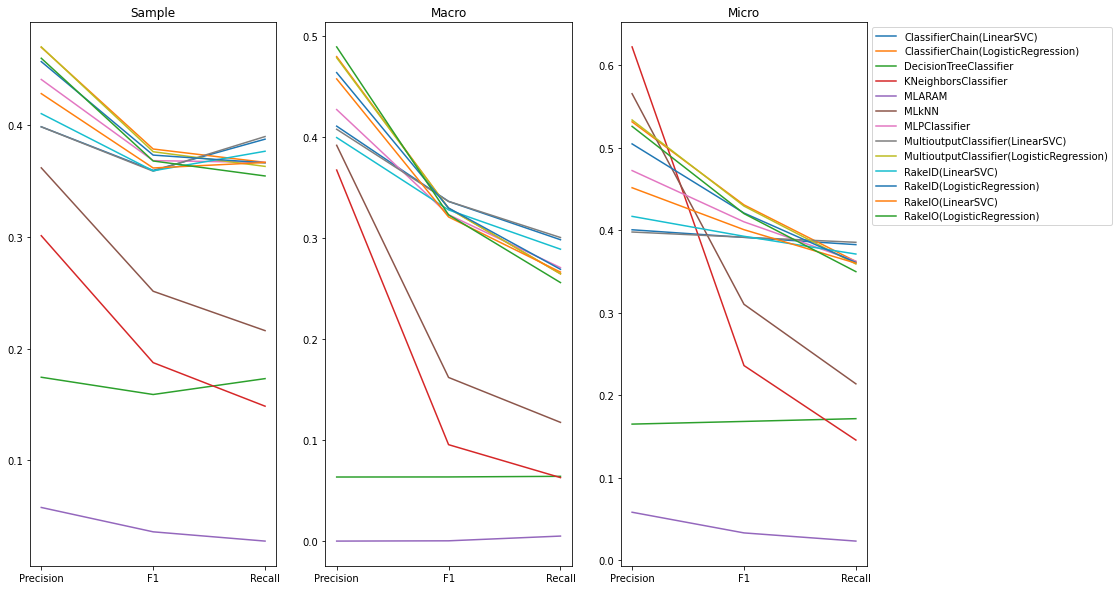

In [12]:
x_ = ['Precision', 'F1', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(15,10))
axes[0].set_title('Sample')
axes[1].set_title('Macro')
axes[2].set_title('Micro')
for eval_ in evals:
    evaluator = eval_[1]
    axes[0].plot(x_, [evaluator.precision_samples, evaluator.f1_samples, evaluator.recall_samples], label=eval_[0])
    axes[1].plot(x_, [evaluator.precision_macro, evaluator.f1_macro, evaluator.recall_macro], label=eval_[0])
    axes[2].plot(x_, [evaluator.precision_micro, evaluator.f1_micro, evaluator.recall_micro], label=eval_[0])
axes[2].legend(bbox_to_anchor=(1, 1), ncol=1)
plt.show()

In [13]:
top_3 = sorted(paths, key=lambda x: load(x).evaluation.recall_macro, reverse=True)[:3]

In [14]:
def per_label_accuracy(orig, prediction):
    if not isinstance(prediction, np.ndarray):
        prediction = prediction.toarray()
    l = 1 - orig - prediction
    return np.average(l, axis=0)

In [15]:
from sklearn.metrics import classification_report
classwise_results = []
for clf_path in top_3:
    clf = load(clf_path)
    prediction = clf.predict(test)
    label_accuracies = per_label_accuracy(y_test, prediction)
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    classwise_report = {}
    for i, result in enumerate(report):
        if i < len(label_accuracies):
            classwise_report[result] = report[result]
            classwise_report[result]['accuracy'] = label_accuracies[int(result)]
    classwise_results.append((clf, classwise_report))

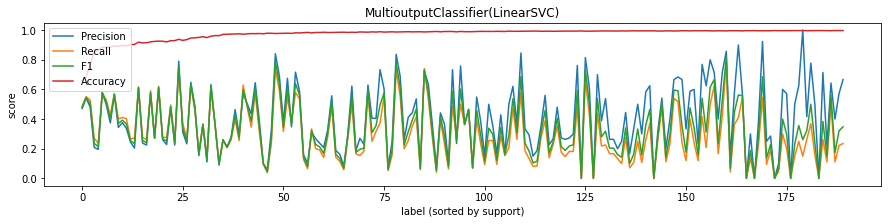

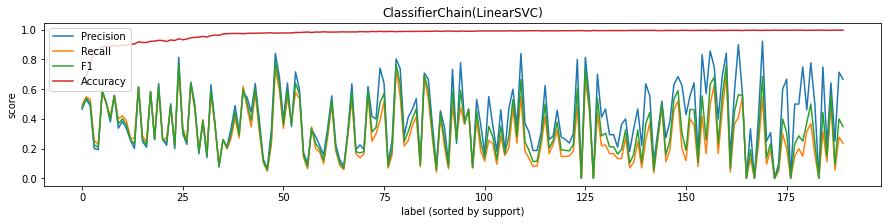

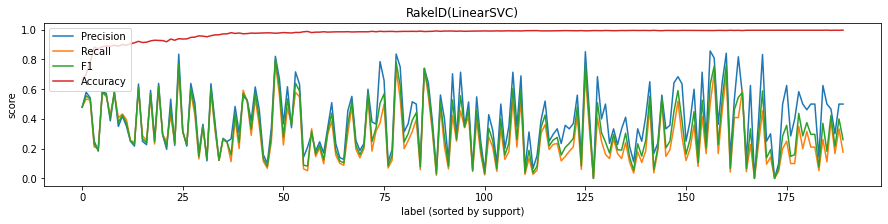

In [16]:
import numpy as np
x_ = np.arange(0, len(y_test[0]))
for classwise_result in classwise_results:
    name, results = classwise_result
    _, fig_1 = plt.subplots(figsize=(15,3))
    fig_1.set_title(name)
    sorted_results = sorted(results, key=lambda x: results[x]['support'], reverse=True)
    fig_1.plot(x_, [results[result]['precision'] for result in sorted_results][0:len(x_)], label='Precision')
    fig_1.plot(x_, [results[result]['recall'] for result in sorted_results][0:len(x_)], label='Recall')
    fig_1.plot(x_, [results[result]['f1-score'] for result in sorted_results][0:len(x_)], label='F1')
    fig_1.plot(x_, [results[result]['accuracy'] for result in sorted_results][0:len(x_)], label="Accuracy")
    fig_1.set_xlabel('label (sorted by support)')
    fig_1.set_ylabel('score')
    fig_1.legend(loc='best')
plt.show()